# CS 4496/7496 Character Animation (Fall 2021)
Copyright (c) Georgia Institute of Technology

---


# Project 2: Integrators (due 10/8/2021, 11:59PM)

![The Leaning Tower of Pisa, Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/The_Leaning_Tower_of_Pisa_SB.jpeg/340px-The_Leaning_Tower_of_Pisa_SB.jpeg)

You are standing at the top of the Leaning Tower of Pisa. Just like Galileo, you are trying to convince people that your numerical integrator is accurate by dropping two balls with equal mass from the tower. One ball follows the analytical equation of free-fall motion while the other one is simulated by your particle system. Your goal is to show that they reach the ground at the same time.

In your program, you will implement an analytical solution and two numerical integration methods: Explicit Euler and Midpoint. Show that one of them yields the same motion as the analytical solution, while the other one does not.

In your results, show three objects side-by-side falling from the same height at the same time with zero initial velocity. Render the object that follows the analytical solution as a red sphere, the object that follows Euler method as a green sphere, and the object following Midpoint method as a blue spehere.

Skeleton code for visualization has already been provided.

In [21]:
# Install pybullet and related requirements
!apt-get install -y xvfb python-opengl ffmpeg
!pip install pybullet==2.6.5
!pip install ffmpeg-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# 1. Skeleton code (do not edit)
### 1.1. Import required libraries

In [26]:
import pybullet as p
import pybullet_data as pd
import time
import ffmpeg
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from PIL import Image
import numpy as np

### 1.2. Initialize Camera and PyBullet Parameters

In [27]:
# Initialize Camera
pixelWidth, pixelHeight = 640, 360
viewMatrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0, 0, 5.0], distance=10.0, yaw=0.0, pitch=0.0, roll=0.0, upAxisIndex=2)
projectionMatrix = p.computeProjectionMatrixFOV(fov=60, aspect=pixelWidth / pixelHeight, nearVal=0.01, farVal=100)
# Initialize PyBullet parameters
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pd.getDataPath())
p.resetSimulation()
flags = p.URDF_INITIALIZE_SAT_FEATURES

### 1.3. Load PyBullet objects and initialize required parameters

In [28]:
# Load objects
plane = p.loadURDF('plane.urdf', [0, 0, 0], flags=flags, useFixedBase=True)
initial_height = 10.0
# Red Sphere - Analytical
obj1Shape = p.createVisualShape(shapeType=p.GEOM_MESH, fileName="sphere_smooth.obj", meshScale=[0.25, 0.25, 0.25], rgbaColor=[1, 0, 0, 1])
obj1 = p.createMultiBody(baseMass=1, baseVisualShapeIndex=obj1Shape, basePosition=[0.0, 0.0, initial_height], flags=flags)
# Green sphere - Euler
obj2Shape = p.createVisualShape(shapeType=p.GEOM_MESH, fileName="sphere_smooth.obj", meshScale=[0.25, 0.25, 0.25], rgbaColor=[0, 1, 0, 1])
obj2 = p.createMultiBody(baseMass=1, baseVisualShapeIndex=obj2Shape, basePosition=[1.0, 0.0, initial_height], flags=flags)
# Blue sphere - Midpoint
obj3Shape = p.createVisualShape(shapeType=p.GEOM_MESH, fileName="sphere_smooth.obj", meshScale=[0.25, 0.25, 0.25], rgbaColor=[0, 0, 1, 1])
obj3 = p.createMultiBody(baseMass=1, baseVisualShapeIndex=obj3Shape, basePosition=[-1.0, 0.0, initial_height], flags=flags)

dt = 1. / 20.  # Time step
g = 9.8  # Acceleration due to gravity
targetPos_obj2, targetVel_obj2 = 0., 0.  # Initialize variables used in Euler method
targetPos_obj3, targetVel_obj3 = 0., 0.  # Initialize variables used in Midpoint method

# 2. Galileo's experiment

The first task is to write the code for defining the "system" of each free-falling object. Particularly, you need to implement a "get_derivative" function, which gives you the derivative of the current state. ** **write your code below (20 pts)**  **

In [25]:
class Freefall(object):
  """ A dynamics system of a freefall object.
  """
  def __init__(self, obj, g, initial_state):
    """Initialize the object that is free-falling.

    Args:
      obj: the object in pybullet
      g: the gravity constant
      initial_state: the initial state at the beginning
    """
    self.obj = obj
    self.g = g
    self.set_state(initial_state)
  
  def get_dim(self):
    """Returns the dimension of the state."""
    return 2

  def get_state(self):
    """Returns the current height and velocity."""
    return self.state

  def set_state(self, state):
    """Updates the height and vertical velocity of the object."""
    self.state = np.array(state)
  
  def get_derivative(self):
    """Returns the derivative of the given system as np.array."""
    # Student answer begins
    der = [self.state[1], -g] #[v,a]
    return der
    # Student answer ends
  
  def update_pybullet(self):
    """Updates the position and velocity of the object for visualization.
    """
    obj = self.obj
    x, y, _ = p.getBasePositionAndOrientation(obj)[0]
    z, dz = self.state
    p.resetBasePositionAndOrientation(obj, posObj=[x, y, z], ornObj=[0, 0, 0, 1])
    p.resetBaseVelocity(obj, linearVelocity=[0, 0, dz]) 


Let's quickly verify your implementation.

In [29]:
system = Freefall(obj=None, g=9.8, initial_state=(10.0, 0.0)) # 10m, zero velocity
assert np.allclose(system.get_derivative(), np.array([0.0, -9.8]))
system.set_state((5.0, -1.0)) # 5.0m, -1.0m/s
assert np.allclose(system.get_derivative(), np.array([-1.0, -9.8]))
print("You pass the tests!")

You pass the tests!


Now it is time to implement all the integrators.

Let's write the analytical solution first. For analytically solving the free-fall motion, we need to know its initial height and gravity constant. Do not use dt, which is not necessary for the analytical solver. ** **write your code below (20 pts)**  **

In [30]:
class AnalyticSolver(object):
  """AnalyticSolver, specific to a free falling object."""
  def __init__(self, initial_height, g):
    """Initializes the solver.

        Args:
          initial_height: initial height of the object.
          g: gravity constant.
    """
    self.initial_height = initial_height
    self.g = g
  
  def step(self, system, t, dt):
    """Set the system state at the given time t. Do not use the argument dt. Call the set_state function while not returning anything."""
    del dt
    #Student answer begins
    system.set_state(((-1/2) * self.g * t**2 + self.initial_height, -self.g * t))
    #new (height, velocity)
    # Student answer ends    

Then the next is the Explicit Euler method. Don't use the time t because we are implementing a numerical integration method. ** **write your code below (20 pts)**  **

In [31]:
class ExplicitEulerSolver(object):
  """A general Explicit Euler method solver."""
  def __init__(self):
    """Initilializes the solver."""
    pass
  
  def step(self, system, t, dt):
    """ Read the current system state and advance the system by dt. Do not use the time t. Do not return anything."""
    del t
    #1. get the current state
    #2. calculate the next state using the (current position + H*get_derivative() function)
    #3. set the new state
    #x0 + h * x'(t0)
    
    # Student answer begins 
    x0 = system.get_state()[0] #height
    v0 = system.get_state()[1] #velocity (negative)
    x1 = system.get_derivative()[0] #v (negative)
    v1 = system.get_derivative()[1] #a (negative)

    #y(t1) = y(t0) + h * y(t0)'
    newHeight = x0 + dt * x1
    #v(t1) = v(t0) + h * v(t0)'
    newVelocity = v0 + dt * v1 

    system.set_state((newHeight, newVelocity)) #(v(t1), y(t1))

    # Student answer ends        

The third one is the Midpoint method (hint: compute x_mid and f_mid. don't forget to store the original state x0). ** **write your code below (20 pts)**  **

In [32]:
class MidpointSolver(object):
  """A general Midpoint method solver."""
  def __init__(self):
    """Initilializes the solver."""
    pass
  
  def step(self, system, t, dt):
    """ Read the current system state and advance the system by dt. Do not use the time t. Do not return anything."""
    del t
    # Student answer begins 

    #Compute an Euler step
    x0 = system.get_state()[0] #height
    v0 = system.get_state()[1] #velocity (negative)
    x1 = system.get_derivative()[0] #v (negative)
    v1 = system.get_derivative()[1] #a (negative)

    x_midx = x0 + (dt/2) * x1 #x0 + h/2 * v0
    x_midv = v0 + (dt/2) * v1 #v0 - h/2 * g

    system.set_state((x_midx, x_midv))
    
    f_midx = system.get_derivative()[0]
    f_midv = system.get_derivative()[1]

    #f_midx = x_midv #v0 - h/2 * g
    #f_midv = v1 #-g

    newStateHeight = x0 + dt * f_midx #x0 + h * fmid
    newStateVelocity = v0 + dt * f_midv #v0 + h * fmid

    system.set_state((newStateHeight, newStateVelocity)) 
    # Student answer ends        

Complete the while-loop below by calling the step functions.

In [33]:
def get_heights(systems):
  """A helper function that returns the heights of all systems."""
  return [s.get_state()[0] for s in systems]

i, t = 0, 0.  # Loop counter, Time
heightsToPlot = [[initial_height], [initial_height], [initial_height]]
time = [t]

# Constructs all the systems
init_state = np.array((initial_height, 0.0))
system1 = Freefall(obj1, g, init_state)
system2 = Freefall(obj2, g, init_state)
system3 = Freefall(obj3, g, init_state)
systems = [system1, system2, system3]

# Constructs all the solvers
analytic_solver = AnalyticSolver(initial_height, g)
explicit_euler_solver = ExplicitEulerSolver()
midpoint_solver = MidpointSolver()

while max(get_heights(systems)) > 0.0:
  time.append(t)
  t += dt

  analytic_solver.step(system1, t, dt)
  explicit_euler_solver.step(system2, t, dt)
  midpoint_solver.step(system3, t, dt)
  heights = get_heights(systems)

  # Print the values for debugging.
  if i % 5 == 0:    
      print("At time t = {}".format(t))
      print("Height of object using analytical solution = {}".format(heights[0]))
      print("Height of object using Euler method = {}".format(heights[1]))
      print("Height of object using Mid Point method = {}".format(heights[2]))

  # Update the values for plot and visualization
  for j, system_j in enumerate(systems):
    system_j.update_pybullet()
    heightsToPlot[j].append(heights[j])

  # Render images
  _, _, img, _, _ = p.getCameraImage(pixelWidth, pixelHeight, viewMatrix,projectionMatrix, shadow=1, lightDirection=[1,1,1])
  Image.fromarray(img[:, :, :3]).save('./frame%04d.jpg' % i)
  i += 1

print("Done. t = {}".format(t))

At time t = 0.05
Height of object using analytical solution = 9.98775
Height of object using Euler method = 10.0
Height of object using Mid Point method = 9.98775
At time t = 0.3
Height of object using analytical solution = 9.559
Height of object using Euler method = 9.6325
Height of object using Mid Point method = 9.559
At time t = 0.5499999999999999
Height of object using analytical solution = 8.51775
Height of object using Euler method = 8.652500000000002
Height of object using Mid Point method = 8.51775
At time t = 0.8000000000000002
Height of object using analytical solution = 6.863999999999999
Height of object using Euler method = 7.0600000000000005
Height of object using Mid Point method = 6.863999999999998
At time t = 1.0500000000000003
Height of object using analytical solution = 4.597749999999997
Height of object using Euler method = 4.8549999999999995
Height of object using Mid Point method = 4.597749999999998
At time t = 1.3000000000000005
Height of object using analytical 

#### Let us now visualize the results of our experiments, Make sure that you can see the animation of three free-falling objects.


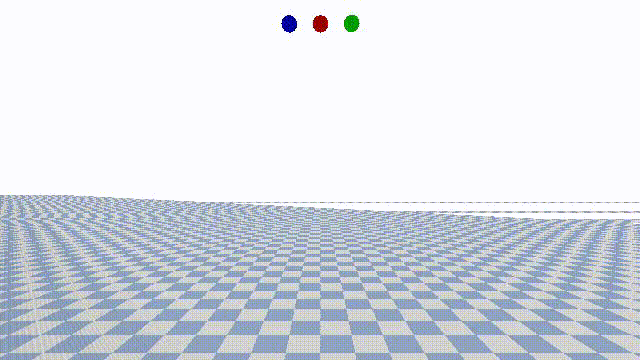

In [34]:
def show_gif_image(filename):
  video = io.open(filename, 'r+b').read()
  encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<img src="data:image/gif;base64,{0}"/>'''.format(encoded.decode('ascii'))))

# Zip the animation in to gif
ffmpeg.input('./frame*.jpg', pattern_type='glob', framerate=20.0).output('./output.gif').overwrite_output().run()
show_gif_image('./output.gif')

#### Let us also look at the plot of heights vs time:

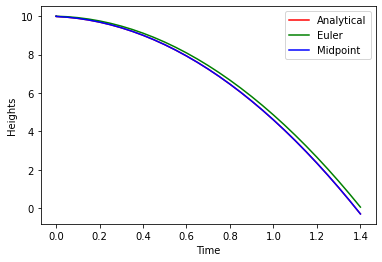

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

time = time[:-1]
heightsToPlot[0] = heightsToPlot[0][:-1]
heightsToPlot[1] = heightsToPlot[1][:-1]
heightsToPlot[2] = heightsToPlot[2][:-1]
plt.figure()
plt.plot(time, heightsToPlot[0], 'r-', label='Analytical')
plt.plot(time, heightsToPlot[1], 'g-', label='Euler')
plt.plot(time, heightsToPlot[2], 'b-', label='Midpoint')
plt.xlabel('Time')
plt.ylabel('Heights')
plt.legend()
plt.show()

Can you see all three height trajectories over time? Discuss the results, particularly in terms of the accuracy of each method. Will the results be different if we take a smaller/larger time step? ** **write your answer below (20 pts)** **

I can see all three height trajectories. 

The mid point method yields the same motion as the analytical solution whereas the Euler method does not. If we take a larger time step, the difference between the Euler method's result and the analytical solution's result will be increased, making the results of these two methods less well-matched; the mid point method will still yield the same results as the analytical solution. On the other hand, if we take a smaller time step, the results of the Euler method and the analytical method will look more similar, making the results more well-matched. For comparison, I adjusted the dt from 1./20. to 1./10. and 1./50.. 

Using the biggest time step (1./10.) out of these three for the methods led to this plot:

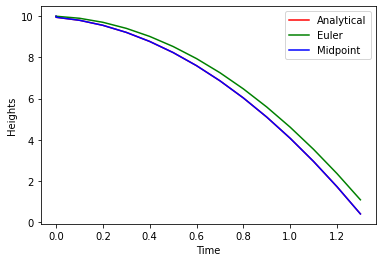  

Using the smallest time step (1./50.) drew this plot: 

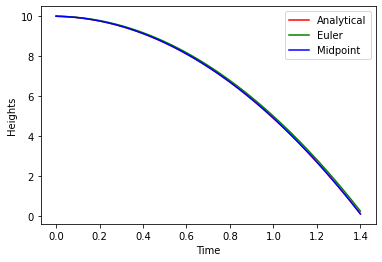

As shown in the plots, the changes from the original plot are pretty noticible; the one with the smallest time step seems the most identical to one another, and the one with the biggest time step shows a big gap between the lines suggesting a bigger difference in the results. 

# 3. Extra Questions

3.1. Do you remember the bead-on-wire example? In this task, we will implement the system of the bead-on-wire where a 2-D particle is governed with two springs in X and Y axis, where their stiffness are $1.0$ and $k$, respectively. ** **write your code below (3 pts)**  **


In [ ]:
class BeadOnWire(object):
  '''A bead on the wire system integrated using Euler and Midpoint methods
  '''
  def __init__(self, k, initial_state):
    '''Initialize system parameters

    Args:
    k: Spring constant
    initial_state: Initial system state
    '''
    self.k = k
    self.set_state(initial_state)
  
  def get_state(self):
    '''Returns [x(t), y(t)], where x = e^(-t) and y = e^(-kt)
    '''
    return self.state

  def set_state(self, state):
    '''Update x(t) and y(t), where x = e^(-t) and y = e^(-kt)
    '''
    self.state = np.array(state)

  def get_derivative(self):
    '''Derivative of given system [-e^(-t), -ke^(-kt)]
    '''
    # Student answer begins 
    # Student answer ends   


We provide the skeleton code for simulation.

In [ ]:
# Create a bead-on-wire system with desired parameters
k = 5
initial_state = np.array([1, 1]) # [e^(-0), e^(-k * 0)]
b_Euler = BeadOnWire(k, initial_state)
b_Midpoint = BeadOnWire(k, initial_state)
# Simulation parameters
dt = 1./ 4.
numTimeSteps = 50
# Lists to store histories which we will plot later
histEuler, histMidpoint = [initial_state], [initial_state]

# The mainloop for simulation
for t in range(numTimeSteps):
  explicit_euler_solver.step(b_Euler, t, dt)
  histEuler.append(b_Euler.get_state())
  midpoint_solver.step(b_Midpoint, t, dt)
  histMidpoint.append(b_Midpoint.get_state())
histEuler, histMidpoint = np.array(histEuler), np.array(histMidpoint)

... and the code for visualization as well.

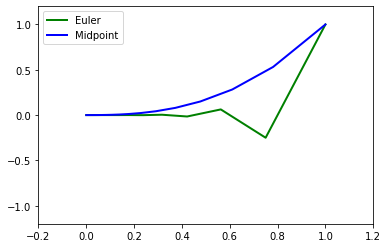

In [ ]:
from matplotlib import animation, rc

# Set up initial figure
fig, ax = plt.subplots()
ax.set_xlim(( -0.2, 1.2))
ax.set_ylim((-1.2, 1.2))
colors = ["Green", "Blue"]
labels = ["Euler", "Midpoint"]

lines = []
for i in range(2):
  lines.append(ax.plot([], [], lw=2, color=colors[i], label=labels[i])[0])

# Initialization function: plot the background of each frame
def init():
  for line in lines:
    line.set_data([], [])
  return lines

# Animation function. This is called sequentially
def animate(i):
  xEuler, yEuler = histEuler[:i + 1, 0], histEuler[:i + 1, 1]
  xMid, yMid = histMidpoint[:i + 1, 0], histMidpoint[:i + 1, 1]
  x = [xEuler, xMid]
  y = [yEuler, yMid]
  for lineNum, line in enumerate(lines):
    line.set_data(x[lineNum], y[lineNum])

  ax.legend()
  return lines

# Call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=numTimeSteps, interval=50, blit=True)
HTML(anim.to_html5_video())

3.2. Implement an additional integrator, RK4, and test it with the bead-on-wire example. ** **write your code below (3 pts)**  **

In [ ]:
class RK4Solver(object):
  def __init__(self):
    pass
  
  def step(self, system, t, dt):
    pass

3.3. Implement an additional integrator, implicit Euler, and verify that you can take a large step on the bead-on-wire system. (hint: you may need to implement new member functions to the system.) ** **write your code below (4 pts)**  **

In [ ]:
class ImplicitEulerSolver(object):
  def __init__(self):
    pass
  
  def step(self, system, t, dt):
    pass

# 4. Research Project.
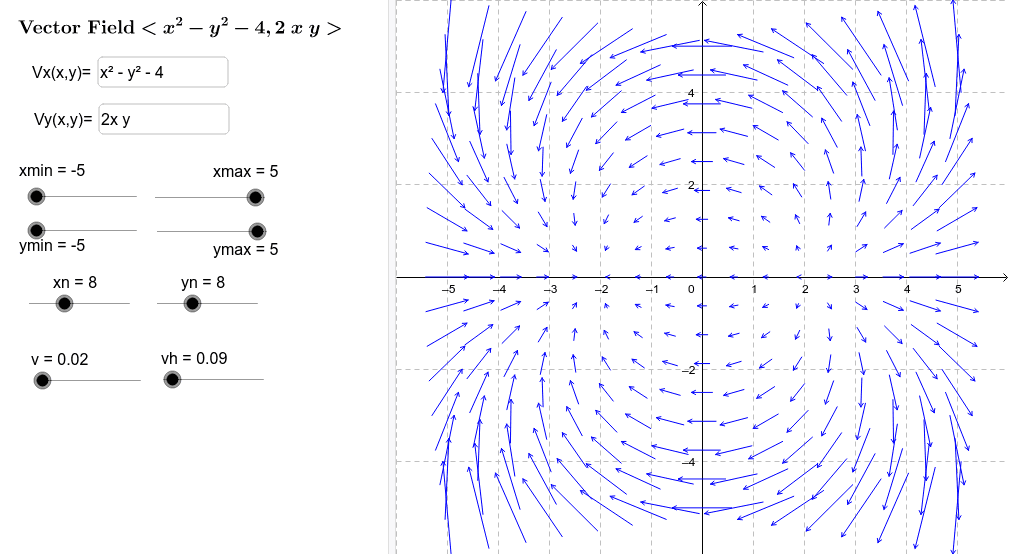
Please develop an interactive tool that you can create/modify/select a vector field. You can drop a ball to the vector field by clicking the screen. Then a ball will follow the given vector field. A user may want to select different integration methods, such as Explicit Euler, Midpoint, or RK4 methods. How can they compare different integrators? I want to see creative solutions.

**Deliverable:**
Please submit the code, the short document (e.g., how to run or how to use) and the demo video in a zip file. Please write down the downloadable link to the cell below.

**Points:**
10 additional points, but the sum of the extra question points and research project points will not exceed 10 points.